# BERT for answering queries related to Stocks

This notebook is an attempt to use BERT as a chat-bot for queries related to stocks. 

## References 

1. https://www.youtube.com/watch?v=l8ZYCvgGu0o
2. BERT paper : https://arxiv.org/pdf/1810.04805.pdf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-question-answering-dataset/dev-v1.1.json
/kaggle/input/stanford-question-answering-dataset/train-v1.1.json


In [2]:
!pip install transformers

In [3]:
import torch

# Loading Fine-tuned BERT Large

In [4]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [6]:
print(tokenizer.sep_token_id)

102


# Question-answering model

In [7]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


NameError: name 'start_scores' is not defined

In [8]:

def print_score_graph(start_scores, end_scores, tokens):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
    s_scores = start_scores.detach().numpy().flatten()
    e_scores = end_scores.detach().numpy().flatten()

    # We'll use the tokens as the x-axis labels. In order to do that, they all need
    # to be unique, so we'll add the token index to the end of each one.
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))


    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    #sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (24,8)
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)

    plt.title('Start Word Scores')

    plt.show()



In [9]:
def stock_chat_bot(question, passage):
    # ====Tokenize====
    # Apply tokenizer to input text and treat them as a pair
    input_ids = tokenizer.encode(question, passage)
    
    # Printing the length of sequence
    print('Query has {} tokens.'.format(len(input_ids)))
    
    # ====Set Segment IDs====
    # Search for the first instance of segment ID
    sep_index = input_ids.index(tokenizer.sep_token_id)
    
    # Segment A token : The Question
    num_seg_a = sep_index+1
    
    # Segment B token : The Answer
    num_seg_b = len(input_ids) - num_seg_a
    
    # Constructing list of 0s and 1s
    # 0s of Segment A and 1s for Segment B
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    # There should be a segment id for every input token
    assert len(segment_ids) == len(input_ids)
    
    start_scores, end_scores = model(torch.tensor([input_ids]), # input text token
                                    token_type_ids = torch.tensor([segment_ids])) # differentiates between question and answer text
    
    # ==== Reconstruct Answer ====
    # print the answer with max start and end scores
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    
    # Get the string version of input tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    answer = tokens[answer_start]
    
    for i in range(answer_start+1, answer_end+1):
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        else:
            answer += ' '+tokens[i]
    
    print_score_graph(start_scores, end_scores, tokens)
    
    print('Answer : ', answer)
            
            
    

In [10]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# sample report taken from economic times on corona virus
# https://economictimes.indiatimes.com/markets/coronavirus-impact-on-stock-market

bert_abstract = "The coronavirus outbreak, which was first detected in China, has infected people in 185 countries. Its spread has left businesses around the world counting the costs.Here is a selection of maps and charts to help you understand the economic impact of the virus so far.Global shares take a hit. Big shifts in stock markets, where shares in companies are bought and sold, can affect the value of pensions or individual savings accounts (ISAs). The FTSE, Dow Jones Industrial Average and the Nikkei have all seen huge falls since the outbreak began on 31 December. The Dow and the FTSE saw their biggest quarterly drops in the first three months of the year since 1987 due to corona pandemic. Investors fear the spread of the coronavirus will destroy economic growth and that government action may not be enough to stop the decline.In response, central banks in many countries, including the United Kingdom, slashed interest rates due to corona pandemic.That should, in theory, make borrowing cheaper and encourage spending to boost the economy."
print(wrapper.fill(bert_abstract))

The coronavirus outbreak, which was first detected in China, has infected people
in 185 countries. Its spread has left businesses around the world counting the
costs.Here is a selection of maps and charts to help you understand the economic
impact of the virus so far.Global shares take a hit. Big shifts in stock
markets, where shares in companies are bought and sold, can affect the value of
pensions or individual savings accounts (ISAs). The FTSE, Dow Jones Industrial
Average and the Nikkei have all seen huge falls since the outbreak began on 31
December. The Dow and the FTSE saw their biggest quarterly drops in the first
three months of the year since 1987 due to corona pandemic. Investors fear the
spread of the coronavirus will destroy economic growth and that government
action may not be enough to stop the decline.In response, central banks in many
countries, including the United Kingdom, slashed interest rates due to corona
pandemic.That should, in theory, make borrowing cheaper an

Query has 223 tokens.


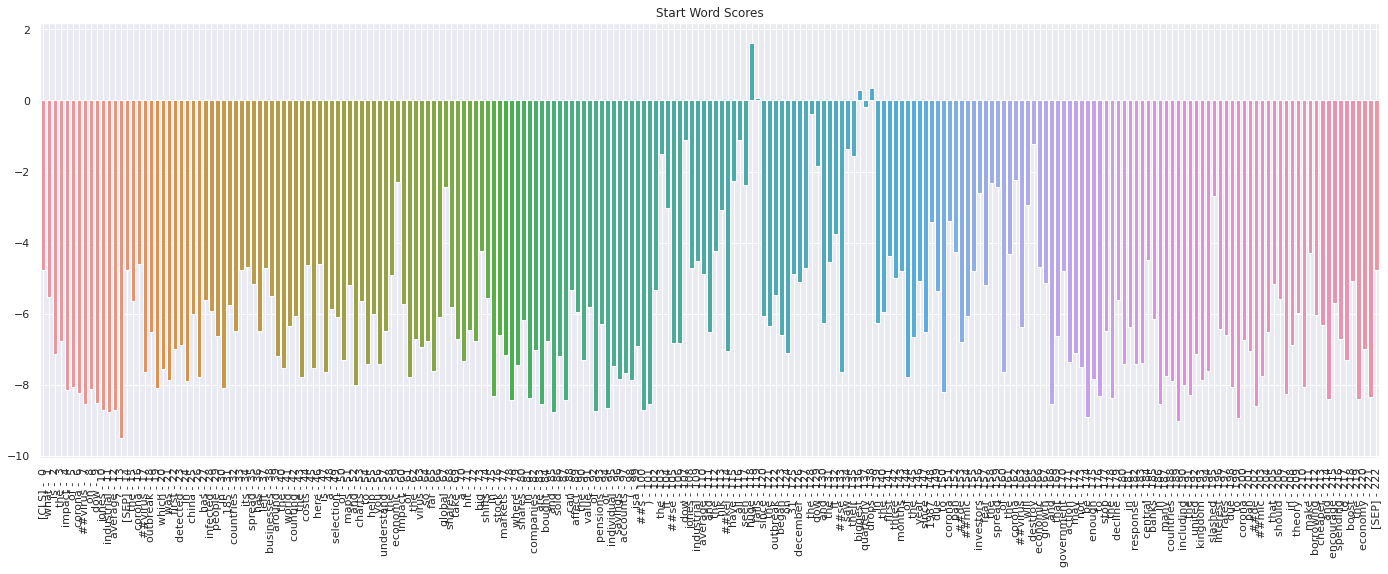

Answer :  huge falls


In [11]:
question = "What is the impact of coronavirus on Dow Jones Industrial Average?"

stock_chat_bot(question, bert_abstract)

Query has 221 tokens.


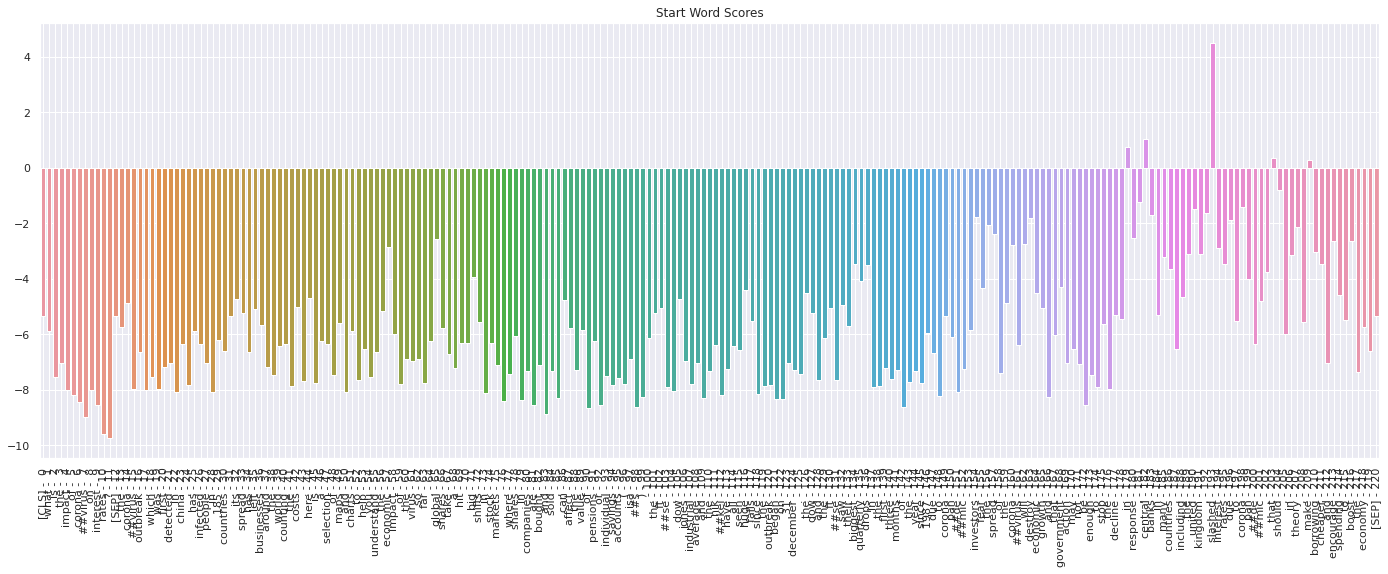

Answer :  slashed interest rates


In [12]:
question = "What is the impact of coronavirus on interest rates?"

stock_chat_bot(question, bert_abstract)